In [1]:
import urllib
import torch
import matplotlib
from torchvision import transforms

from PIL import Image
from depth import getDepthHead
from segmentation import getSegmentationHead, getSegmentationModel
from mmseg.apis import inference_segmentor

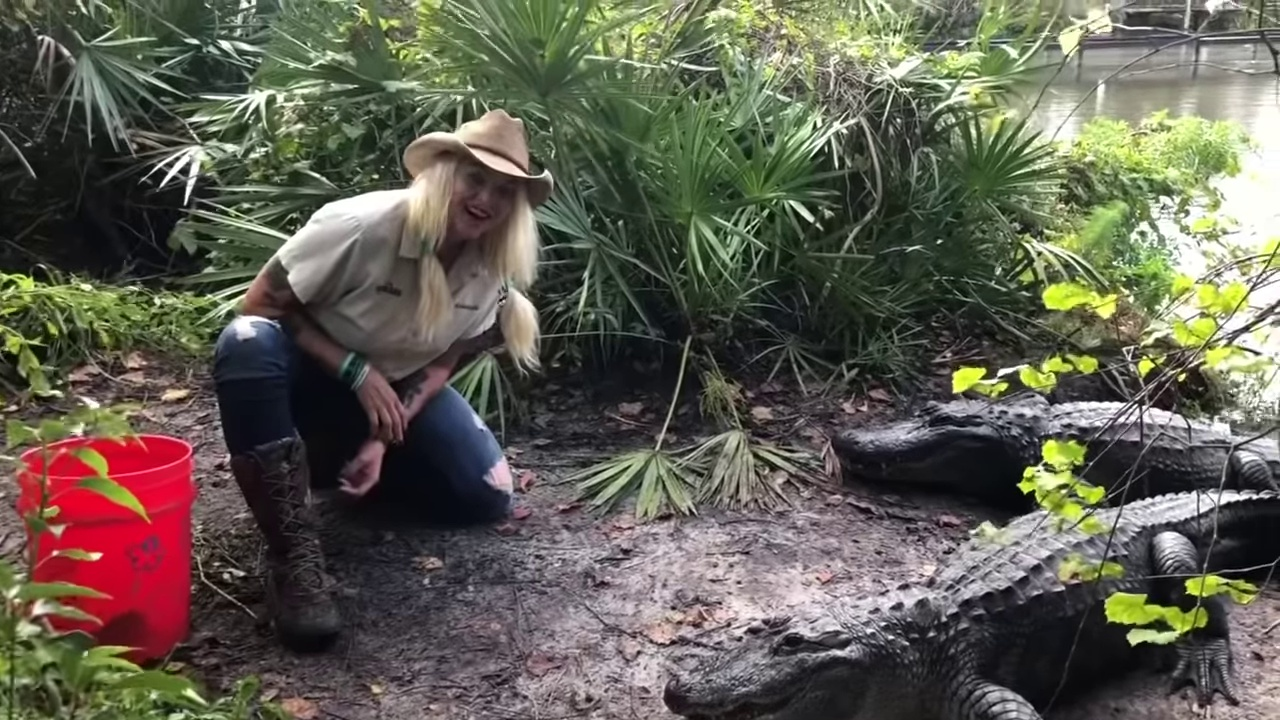

In [2]:
test_image = Image.open(r"S:/CS7643Project/audiosetdl/dataset/image/3-9.#alligators, crocodiles hissing#.train.Alligators Blackwater & Thrasher!  VLOGMAS Day 15.jpg")
display(test_image)

Using cache found in C:\Users\mjh01/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\mjh01/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\mjh01/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\mjh01/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_nyu_dpt_head.pth


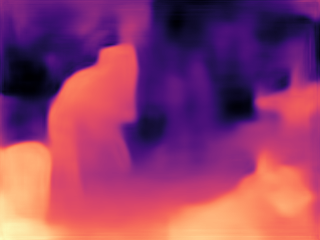

In [3]:
def make_depth_transform() -> transforms.Compose:
    return transforms.Compose([
        transforms.ToTensor(),
        lambda x: 255.0 * x[:3], # Discard alpha component and scale by 255
        transforms.Normalize(
            mean=(123.675, 116.28, 103.53),
            std=(58.395, 57.12, 57.375),
        ),
        transforms.Resize((240, 320)),
    ])


def render_depth(values, colormap_name="magma_r") -> Image:
    min_value, max_value = values.min(), values.max()
    normalized_values = (values - min_value) / (max_value - min_value)

    colormap = matplotlib.colormaps[colormap_name]
    colors = colormap(normalized_values, bytes=True) # ((1)xhxwx4)
    colors = colors[:, :, :3] # Discard alpha component
    return Image.fromarray(colors)


transform = make_depth_transform()

scale_factor = 1
rescaled_image = test_image.resize((scale_factor * test_image.width, scale_factor * test_image.height))
transformed_image = transform(rescaled_image)
batch = transformed_image.unsqueeze(0).cuda() # Make a batch of one image

model = getDepthHead().cuda()

with torch.inference_mode():
    result = model.whole_inference(batch, img_meta=None, rescale=True)

depth_image = render_depth(result.squeeze().cpu())
display(depth_image)

d:\CS7643\project\ImageToAudio\model\layer\../..\model\dinov2\eval\segmentation_m2f\models\losses\cross_entropy_loss.py:222: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
d:\Program_Files\anaconda3\envs\imagetoaudio4\lib\site-packages\mmcv\ops\multi_scale_deform_attn.py:216: UserWarning: You'd better set embed_dims in MultiScaleDeformAttention to make the dimension of each attention head a power of 2 which is more efficient in our CUDA implementation.
  warnings.warn(


load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_ade20k_m2f.pth


d:\Program_Files\anaconda3\envs\imagetoaudio4\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
d:\CS7643\project\ImageToAudio\model\layer\../..\model\dinov2\eval\segmentation_m2f\models\utils\positional_encoding.py:77: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_feats)


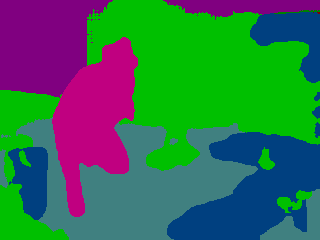

In [4]:
import numpy as np

import model.dinov2.eval.segmentation.utils.colormaps as colormaps


DATASET_COLORMAPS = {
    "ade20k": colormaps.ADE20K_COLORMAP,
    "voc2012": colormaps.VOC2012_COLORMAP,
}

HEAD_DATASET = "voc2012"

def make_segmentation_transform() -> transforms.Compose:
    return transforms.Compose([
        # transforms.ToTensor(),
        # lambda x: 255.0 * x[:3], # Discard alpha component and scale by 255
        # transforms.Normalize(
        #     mean=(123.675, 116.28, 103.53),
        #     std=(58.395, 57.12, 57.375),
        # ),
        transforms.Resize((240, 320)),
    ])

def render_segmentation(segmentation_logits, dataset):
    colormap = DATASET_COLORMAPS[dataset]
    colormap_array = np.array(colormap, dtype=np.uint8)
    segmentation_logits[segmentation_logits + 1 >= colormap_array.shape[0]] = colormap_array.shape[0] - 2
    segmentation_values = colormap_array[segmentation_logits + 1]
    return Image.fromarray(segmentation_values)

transform = make_segmentation_transform()

transformed_image = transform(test_image)

seg_model = getSegmentationModel()

array = np.array(transformed_image)[:, :, ::-1] # BGR
segmentation_logits = inference_segmentor(seg_model, array)[0]
segmented_image = render_segmentation(segmentation_logits, HEAD_DATASET)
display(segmented_image)

In [5]:
import numpy as np

In [6]:
def tensor_transform() -> transforms.Compose:
    return transforms.Compose([
        transforms.ToTensor(),
    ])
tensor_transformer = tensor_transform()
transformed_segmented_image = np.array(tensor_transformer(segmented_image)).transpose((1, 2, 0))
transformed_depth_image = np.array(tensor_transformer(depth_image)).transpose((1, 2, 0))

In [7]:
transformed_segmented_image.shape

(240, 320, 3)

In [8]:
transformed_depth_image.shape

(240, 320, 3)

In [9]:
import cv2

In [10]:
gray_segmented_image = cv2.cvtColor(transformed_segmented_image, cv2.COLOR_BGR2GRAY)
cv2.imshow("image", gray_segmented_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [23]:
gray_depth_image = cv2.cvtColor(transformed_depth_image, cv2.COLOR_BGR2GRAY)
cv2.imshow("image", gray_depth_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [12]:
rounded_segmented_image = np.around(gray_segmented_image, decimals=2)
cv2.imshow("image", rounded_segmented_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [42]:
gray_segmented_image==0.44

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [13]:
test_gray_image = np.copy(rounded_segmented_image)
test_gray_image[test_gray_image!=0.47] = 0
test_gray_image[test_gray_image==0.47] = 1
cv2.imshow("image", test_gray_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [50]:
print(test_gray_image)

[[          0           0           0 ...           0           0           0]
 [          0           0           0 ...           0           0           0]
 [          0           0           0 ...           0           0           0]
 ...
 [          0           0           0 ...           1           1           1]
 [          0           0           0 ...           1           1           1]
 [          0           0           0 ...           1           1           1]]


In [14]:
def original_transform() -> transforms.Compose:
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((240, 320)),
    ])
original_tranformer = original_transform()
transformed_original_image = np.array(original_tranformer(test_image)).transpose((1, 2, 0))[:, :, ::-1]
cv2.imshow("image", transformed_original_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [15]:
cv_original_image = cv2.imread(r"S:/CS7643Project/audiosetdl/dataset/image/3-9.#alligators, crocodiles hissing#.train.Alligators Blackwater & Thrasher!  VLOGMAS Day 15.jpg")
cv_original_image = cv2.resize(cv_original_image, (320, 240))
cv2.imshow("image", cv_original_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [22]:
ROI_number = 0
volume_factor = []
for gray_scale in list(np.array(range(101)) / 100.0):
    # Morph open to remove noise
    test_gray_image = np.copy(rounded_segmented_image)
    test_gray_image[test_gray_image!=gray_scale] = 0
    test_gray_image[test_gray_image==gray_scale] = 1
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    opening = cv2.morphologyEx(test_gray_image, cv2.MORPH_OPEN, kernel, iterations=1).astype('uint8')

    masked_depth_image = np.multiply(gray_depth_image, test_gray_image)

    # Find contours, obtain bounding box, extract and save ROI
    cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        # cv2.rectangle(cv_original_image, (x, y), (x + w, y + h), (36,255,12), 0.1)
        if w < 32 or h < 32:
            continue
        # c_mask = np.zeros((240, 320), np.uint8)
        # cv2.drawContours(c_mask, c, -1, (255, 255, 255), -1)
        ROI_depth = masked_depth_image[y:y+h, x:x+w]
        ROI_depth = ROI_depth[ROI_depth != 0]
        ROI_depth_mean = np.mean(ROI_depth)
        ROI_horizontal_factor = (160 - (x + 0.5 * w)) / 320.0
        volume_factor.append((ROI_depth_mean * 0.9 + ROI_horizontal_factor * 0.1, ROI_depth_mean * 0.9 - ROI_horizontal_factor * 0.1))
        ROI = cv_original_image[y:y+h, x:x+w]
        cv2.imwrite('test_images/ROI-{}.png'.format(ROI_number), ROI)
        ROI_number += 1

    # cv2.imshow('image', cv_original_image)
    # cv2.imshow('thresh', test_gray_image)
    # cv2.imshow('opening', opening)
    # cv2.waitKey()

print(volume_factor)

[(0.2943399578332901, 0.2943399578332901), (0.1970723593235016, 0.1311348593235016), (0.3802051901817322, 0.3395801901817322), (0.606953216791153, 0.5247657167911529), (0.422259910106659, 0.4744474101066589), (0.10040825158357622, 0.17853325158357622), (0.7238169276714325, 0.6453794276714325), (0.2431726822257042, 0.16161018222570417), (0.18638445854187013, 0.2135719585418701), (0.37810647785663604, 0.4593564778566361), (0.3315461355447769, 0.31685863554477695)]


In [37]:
from ultralytics import YOLO

detection_model = YOLO('yolov8m.pt')
results = detection_model(test_image)

  0%|          | 0.00/49.7M [00:00<?, ?B/s]


0: 384x640 1 person, 2 elephants, 765.4ms
Speed: 2.6ms preprocess, 765.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


In [38]:
print(results)

[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant'